In [282]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import make_interp_spline

#Author: Mohammed Mohideen
# Financial Portfolio Optimization with Artificial Bee Colony 

# Objective Function
## Pareto Frontier of Sharpe Ratio and ESG Score

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\sum_{i=1}^n w_i \mu_i - R_f}{\sqrt{w^T \Sigma w}}
$$

Where:
- $μ_i$ = Portfolio return  
- $R_f$ = Risk-free rate  
- $σ_p$ = Portfolio volatility (standard deviation)
- $Σw$	= Covariance matrix

In [43]:
# gather ticker info from Alpha Vantage API
API_KEY = "OD76BXNCWU9GO4WP"
symbols = ["MSFT", "AAPL", "NVDA", "UNH", "JNJ"]
test = ["FNCMX", "FSELX", "FSPGX", "FTIHX", "FXAIX", "FZROX"]

weights = []

esg_scores = [85,80,75,70,65]

def fetch_daily_prices(ticker):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": ticker,
        "apikey": API_KEY,
        "outputsize": "full"
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check for valid time series key
    time_series_key = next((key for key in data if "Time Series" in key), None)
    if not time_series_key:
        print(f"[Error] No time series for {ticker}. Response: {data}")
        return pd.Series(dtype=float)  # Empty series

    df = pd.DataFrame(data[time_series_key]).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df["close"] = df["4. close"].astype(float)

    return df["close"].iloc[-1260:]  # Last 5 years of trading days

def fetch_all_prices(symbols, output_file="daily_close_prices.csv"):
    all_prices = {}

    for i, symbol in enumerate(symbols):
        print(f"[{i+1}/{len(symbols)}] Fetching {symbol}...")
        all_prices[symbol] = fetch_daily_prices(symbol)

    df = pd.DataFrame(all_prices)
    df.to_csv(output_file)
    print(f"\n Saved data to {output_file}")
    return df

In [30]:

df_prices = fetch_all_prices(symbols)

[1/5] Fetching MSFT...
[2/5] Fetching AAPL...
[3/5] Fetching NVDA...
[4/5] Fetching UNH...
[5/5] Fetching JNJ...

 Saved data to daily_close_prices.csv


In [45]:
cached_5prices = df_prices
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    # Ensure weights are non-negative and sum to 1
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    # Calculate daily returns
    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    # Portfolio return
    portfolio_return = np.dot(weights, mean_annual_returns)

    # Portfolio volatility (handling zero variance case)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        print(f"[Warning] Zero or negative portfolio variance for weights: {weights}")
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)

    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)

    # ESG score
    esg_score = np.dot(weights, esg_vector)

    return sharpe_ratio, esg_score

In [340]:
def dominates(a, b, epsilon=1e-6):
    """
    Efficient dominance check with a small tolerance.
    """
    strictly_better = False
    for x, y in zip(a, b):
        if x < y - epsilon:
            return False  # Early exit if a is not better in any dimension
        elif x > y + epsilon:
            strictly_better = True

    return strictly_better
    
def update_pareto_archive(archive, candidate_objectives, candidate_weights, precision=3):
    """
    Archive update with rounded comparison to avoid floating-point duplicates.
    Stores full-precision solutions, but uses rounded objectives for uniqueness.
    """
    candidate_key = tuple(np.round(candidate_objectives, precision))
    candidate_tuple = (*candidate_objectives, tuple(candidate_weights))

    # Check if candidate (rounded) is already in the archive
    archive_keys = [tuple(np.round((s, e), precision)) for s, e, w in archive]
    if candidate_key in archive_keys:
        return archive

    # Filter archive using domination logic (full precision)
    filtered_archive = []
    for (s, e, w) in archive:
        if dominates((s, e), candidate_objectives):
            return archive  # Candidate is dominated
        if not dominates(candidate_objectives, (s, e)):
            filtered_archive.append((s, e, w))  # Keep non-dominated

    # Add the new candidate
    filtered_archive.append(candidate_tuple)
    return filtered_archive

def normalize_weights(w, min_weight=0.01, max_weight=0.3):
    # Leniently enforce minimum and maximum weight
    w = np.clip(w, min_weight, max_weight)
    return w / np.sum(w)
    
def initialize_population(num_bees, prices_df, esg_vector):
    num_assets = prices_df.shape[1]  # number of stocks

    foods = []
    objectives = []
    trials = np.zeros(num_bees)
    pareto_archive = []

    for _ in range(num_bees):
        # Step 1: Generate random weight vector
        weights = normalize_weights(0.1 + 0.9 * np.random.rand(num_assets))

        # Step 2: Evaluate objectives (Sharpe, ESG)
        sharpe, esg = evaluate_objectives(weights, prices_df, esg_vector)

        # Step 3: Add to food list and objectives
        foods.append(weights)
        objectives.append((sharpe, esg))

        # Step 4: Update Pareto archive
        pareto_archive = update_pareto_archive(pareto_archive, (sharpe, esg), weights)
    return foods, objectives, trials, pareto_archive
    
def employed_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        # Step 1: Pick a random parameter (asset weight) to mutate
        param2change = random.randint(0, num_assets - 1)

        # Step 2: Pick a different random neighbor bee
        neighbour = random.randint(0, num_bees - 1)
        while neighbour == i:
            neighbour = random.randint(0, num_bees - 1)

        # Step 3: Generate new solution by ABC mutation formula
        phi = (random.random() - 0.5) * 2
        candidate = np.copy(foods[i])
        candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

        # Step 4: Clip and normalize the candidate
        candidate = normalize_weights(candidate)
        # Step 5: Evaluate objectives
        new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

        # Step 6: Compare and decide
        if dominates(new_objectives, objectives[i]):
            # Accept new solution
            foods[i] = candidate
            objectives[i] = new_objectives
            trials[i] = 0
        else:
            trials[i] += 1  # No improvement

        # Step 7: Update Pareto archive regardless
        pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

    return foods, objectives, trials, pareto_archive

def compute_probabilities(objectives):
    sharpes = [s for s, e in objectives]
    esgs = [e for s, e in objectives]

    # Normalize to [0, 1]
    sharpes_norm = [(s - min(sharpes)) / (max(sharpes) - min(sharpes) + 1e-8) for s in sharpes]
    esgs_norm = [(e - min(esgs)) / (max(esgs) - min(esgs) + 1e-8) for e in esgs]

    # Combine them
    scores = [(0.5 * s + 0.5 * e) for s, e in zip(sharpes_norm, esgs_norm)]
    total = sum(scores)
    probabilities = [s / total for s in scores]
    return probabilities

def onlooker_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])
    probabilities = compute_probabilities(objectives)

    i = 0
    t = 0
    while t < num_bees:
        if random.random() < probabilities[i]:
            t += 1

            # Mutation
            param2change = random.randint(0, num_assets - 1)
            neighbour = random.randint(0, num_bees - 1)
            while neighbour == i:
                neighbour = random.randint(0, num_bees - 1)

            phi = (random.random() - 0.5) * 2
            candidate = np.copy(foods[i])
            candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

            candidate = normalize_weights(candidate)

            new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

            if dominates(new_objectives, objectives[i]):
                foods[i] = candidate
                objectives[i] = new_objectives
                trials[i] = 0
            else:
                trials[i] += 1

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

        i = (i + 1) % num_bees

    return foods, objectives, trials, pareto_archive

def scout_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit=10):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        if trials[i] >= limit:
            # Replace this food source with a new random one
            new_weights = 0.1 + 0.2 * np.random.rand(num_assets)
            new_weights = new_weights / np.sum(new_weights)

            new_objectives = evaluate_objectives(new_weights, prices_df, esg_vector)

            foods[i] = new_weights
            objectives[i] = new_objectives
            trials[i] = 0  # reset trial count

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, new_weights)

    return foods, objectives, trials, pareto_archive
    
def plot_pareto_archive(archive, cycle):
    sharpes = [s for s, e, _ in archive]
    esgs = [e for s, e, _ in archive]

    plt.figure(figsize=(6, 4))
    plt.scatter(esgs, sharpes, alpha=0.6)
    plt.xlabel("ESG Score")
    plt.ylabel("Sharpe Ratio")
    plt.title(f"Pareto Frontier at Cycle {cycle}")
    plt.grid(True)
    plt.show()

def run_abc(prices_df, esg_vector, num_bees=20, max_cycles=100, limit=10, patience=15):
    # Init phase 
    foods, objectives, trials, pareto_archive = initialize_population(
        num_bees, prices_df, esg_vector
    )

    cycle = 0
    no_change_count = 0
    prev_archive_objs = set()

    while cycle < max_cycles and no_change_count < patience:
        # Employed Phase 
        foods, objectives, trials, pareto_archive = employed_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Onlooker Phase 
        foods, objectives, trials, pareto_archive = onlooker_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Scout Phase 
        foods, objectives, trials, pareto_archive = scout_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit
        )

        # Plot Every 10 Cycles 
        if cycle % 10 == 0:
            plot_pareto_archive(pareto_archive, cycle)

        # Check for Convergence
        current_objs = set((round(s, 4), round(e, 4)) for s, e, _ in pareto_archive)
        if current_objs == prev_archive_objs:
            no_change_count += 1
        else:
            no_change_count = 0
            prev_archive_objs = current_objs

        cycle += 1

    return pareto_archive

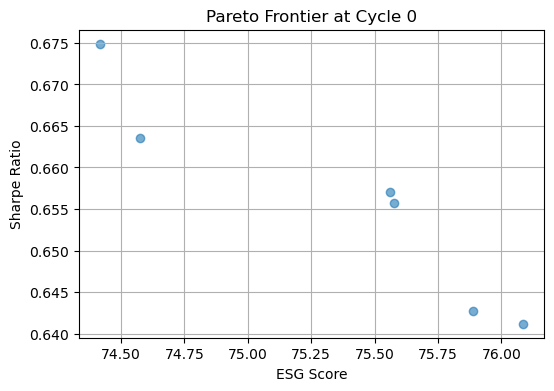

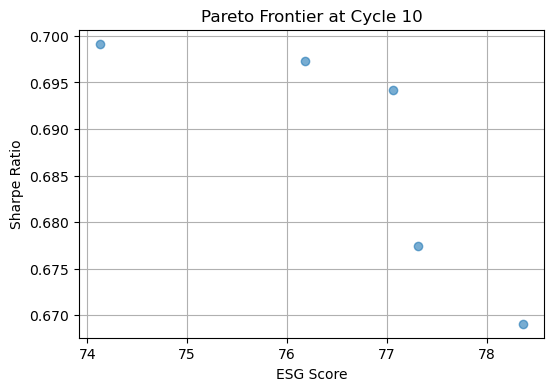

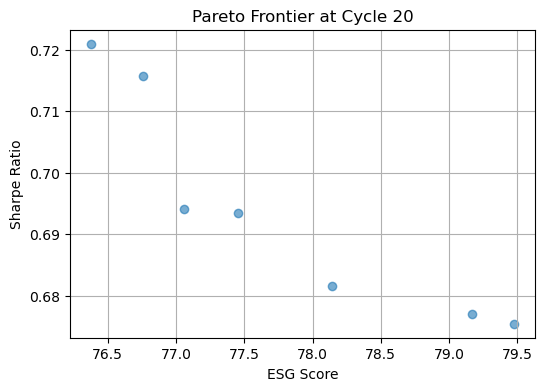

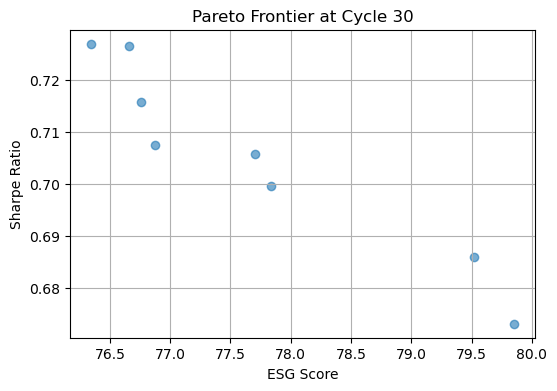

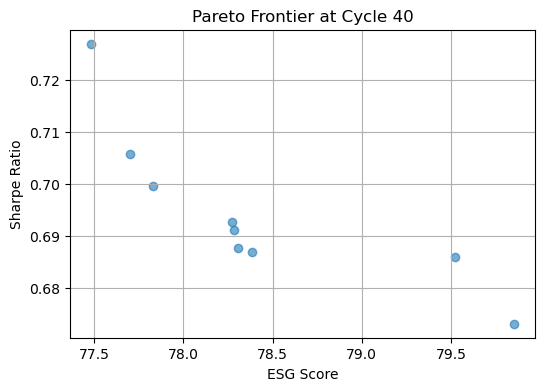

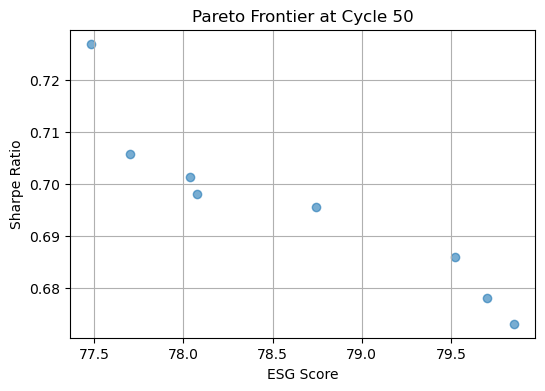

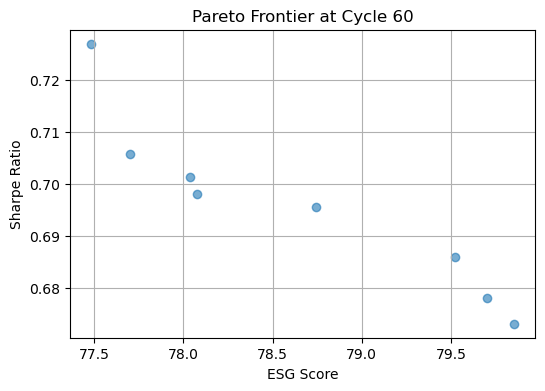

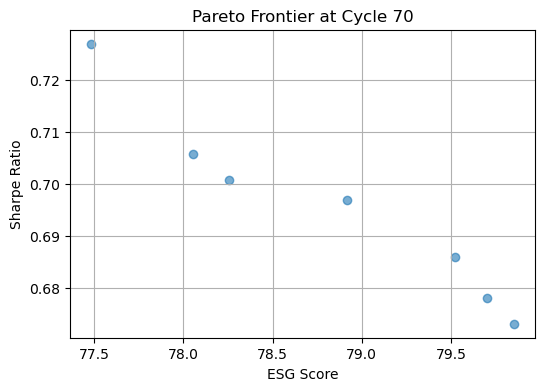

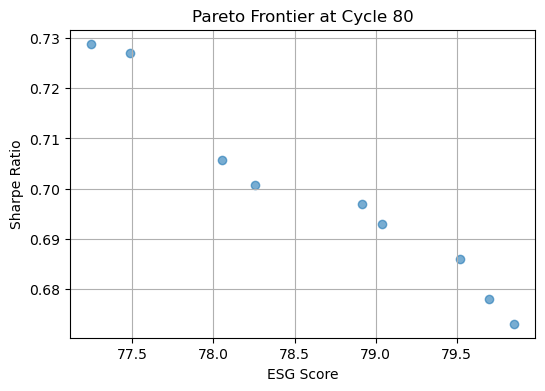

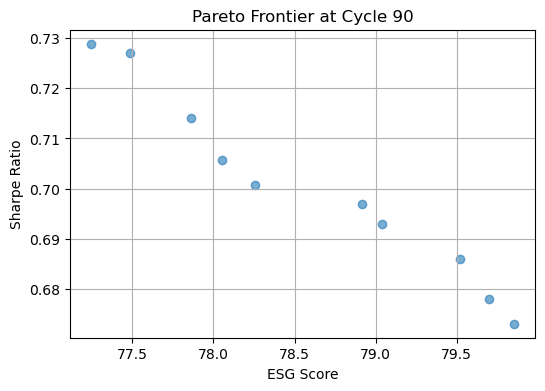

In [342]:
esg_vector = np.array(esg_scores)
pareto_test = run_abc(df_prices, esg_scores, num_bees = 20, max_cycles = 100, limit = 15, patience = 20)

In [344]:
sorted_by_sharpe = sorted(pareto_test, key=lambda x: x[0], reverse=True)
sorted_by_esg = sorted(pareto_test, key=lambda x: x[1], reverse=True)
for sharpe, esg, weights in sorted_by_esg:
    print(f"Sharpe: {sharpe:.3f}, ESG: {esg:.1f}, Weights: {np.round(weights, 2)}")

Sharpe: 0.673, ESG: 79.9, Weights: [0.36 0.3  0.3  0.02 0.01]
Sharpe: 0.678, ESG: 79.7, Weights: [0.35 0.28 0.35 0.01 0.01]
Sharpe: 0.686, ESG: 79.5, Weights: [0.35 0.26 0.35 0.03 0.01]
Sharpe: 0.709, ESG: 79.1, Weights: [0.37 0.21 0.31 0.11 0.01]
Sharpe: 0.714, ESG: 77.9, Weights: [0.34 0.15 0.28 0.22 0.02]
Sharpe: 0.727, ESG: 77.5, Weights: [0.35 0.06 0.35 0.23 0.01]
Sharpe: 0.729, ESG: 77.2, Weights: [0.35 0.07 0.29 0.29 0.01]


In [338]:
def display_archive(archive, title="Pareto Archive (Sorted)"):
    print(f"\n{title}")
    print("-" * 50)
    for i, (sharpe, esg, weights) in enumerate(archive):
        w_str = ", ".join(f"{w:.2f}" for w in weights)
        print(f"[{i+1}] Sharpe: {sharpe:.4f} | ESG: {esg:.2f} | Weights: [{w_str}]")
display_archive(sorted_by_sharpe, title="Top Portfolios by Sharpe")



Top Portfolios by Sharpe
--------------------------------------------------
[1] Sharpe: 0.7466 | ESG: 75.78 | Weights: [0.35, 0.01, 0.30, 0.13, 0.21]
[2] Sharpe: 0.7436 | ESG: 76.38 | Weights: [0.35, 0.03, 0.31, 0.14, 0.16]
[3] Sharpe: 0.7412 | ESG: 76.87 | Weights: [0.36, 0.01, 0.34, 0.20, 0.08]
[4] Sharpe: 0.7344 | ESG: 77.75 | Weights: [0.37, 0.11, 0.28, 0.17, 0.07]
[5] Sharpe: 0.7103 | ESG: 78.01 | Weights: [0.34, 0.16, 0.26, 0.22, 0.01]
[6] Sharpe: 0.7017 | ESG: 78.28 | Weights: [0.34, 0.20, 0.34, 0.01, 0.11]
[7] Sharpe: 0.6991 | ESG: 78.57 | Weights: [0.34, 0.21, 0.31, 0.13, 0.02]
[8] Sharpe: 0.6962 | ESG: 78.76 | Weights: [0.35, 0.22, 0.35, 0.01, 0.07]
[9] Sharpe: 0.6891 | ESG: 79.16 | Weights: [0.34, 0.24, 0.33, 0.07, 0.01]
[10] Sharpe: 0.6772 | ESG: 79.22 | Weights: [0.35, 0.28, 0.28, 0.04, 0.05]
[11] Sharpe: 0.6758 | ESG: 79.53 | Weights: [0.35, 0.29, 0.29, 0.06, 0.01]
[12] Sharpe: 0.6717 | ESG: 79.69 | Weights: [0.34, 0.30, 0.34, 0.01, 0.01]
[13] Sharpe: 0.6584 | ESG: 79.72

In [300]:
!pip install deap

  Using cached deap-1.4.3-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached deap-1.4.3-cp312-cp312-win_amd64.whl (109 kB)


Final NSGA-II population fitness values:
Individual 0: fitness = (-2.277720594768792, -70.68549624174567)
Individual 1: fitness = (0.04641226422533966, -78.45285281681649)
Individual 2: fitness = (0.01151577435589489, -78.0655069661801)
Individual 3: fitness = (0.0040203248067521785, -76.97519163483801)
Individual 4: fitness = (-1.922873027835035, -71.23742978313967)
Individual 5: fitness = (-2.1378635259198977, -71.19895086704787)
Individual 6: fitness = (-1.5910073370634, -71.99145167856439)
Individual 7: fitness = (-2.125490226139751, -71.21772074303068)
Individual 8: fitness = (-1.0071833094688583, -73.45229291563916)
Individual 9: fitness = (-0.5484136981329644, -74.89251310541712)
Individual 10: fitness = (-1.4702723111865867, -72.00020423652181)
Individual 11: fitness = (-1.4215591840387767, -72.10735351472323)
Individual 12: fitness = (-0.03650563721649443, -76.42300944523654)
Individual 13: fitness = (-0.6762296115797882, -74.5494900984621)
Individual 14: fitness = (-0.4842947

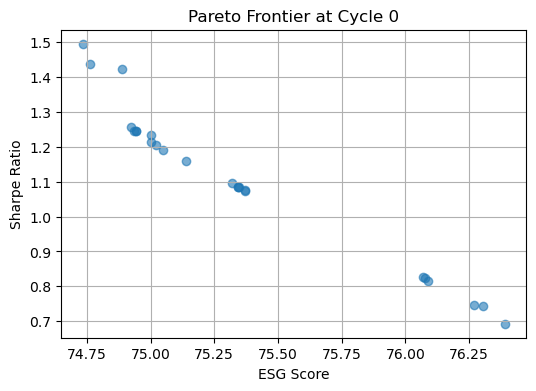

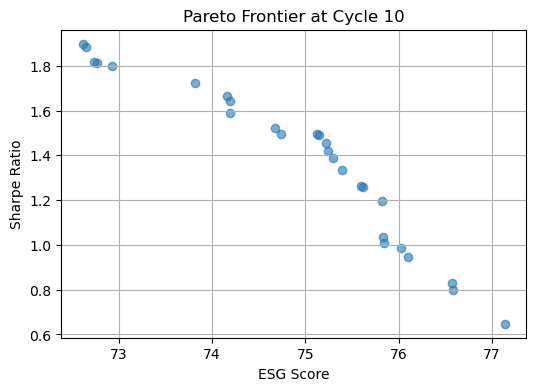

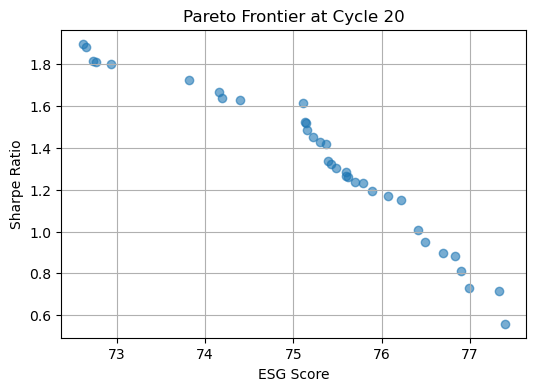

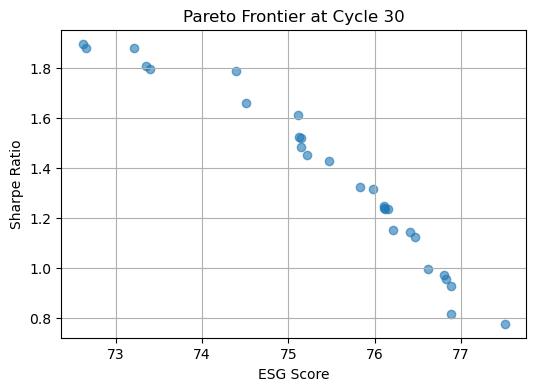

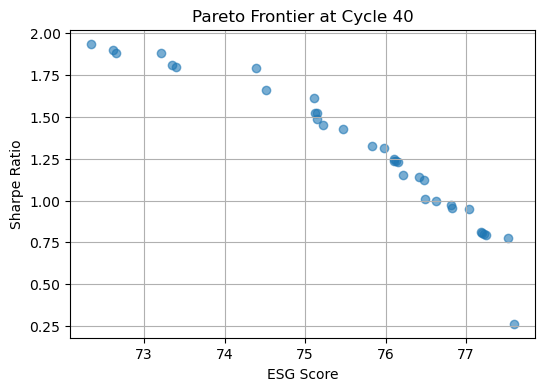

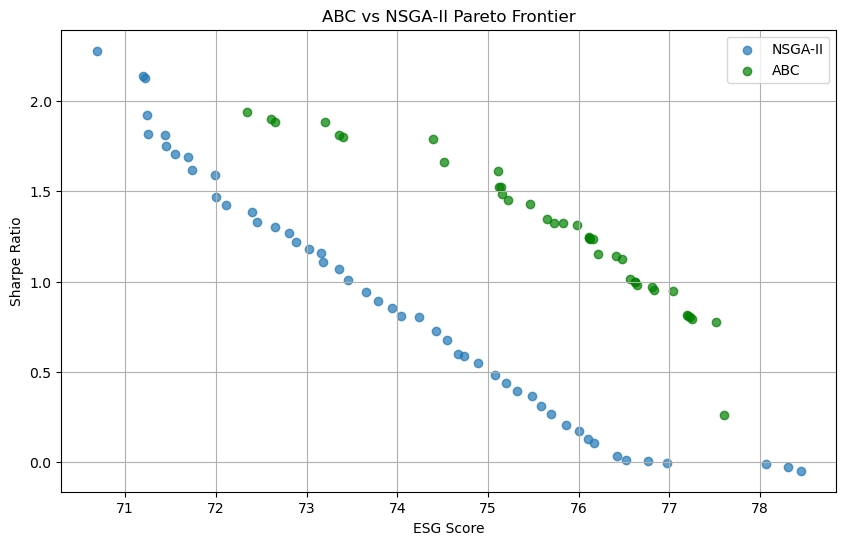

Algorithm Performance Summary:
NSGA-II: 50 solutions, time: 12.88s
ABC:     38 solutions, time: 12.70s


In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import time

# ==== Simulated Data for 5 Assets ====
np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=252)
prices_df = pd.DataFrame(
    np.cumprod(1 + np.random.randn(252, 5) / 100, axis=0) * 100,
    index=dates,
    columns=["A", "B", "C", "D", "E"]
)
esg_scores = np.array([85, 80, 75, 70, 65])

# ==== Portfolio Objective Function ====
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    portfolio_return = np.dot(weights, mean_annual_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)
    esg_score = np.dot(weights, esg_vector)
    return sharpe_ratio, esg_score

def repair_weights(weights, min_w=0.05, max_w=0.3):
    weights = np.nan_to_num(weights, nan=min_w)
    weights = np.clip(weights, min_w, max_w)
    total = np.sum(weights)
    if total == 0:
        weights = np.ones_like(weights) / len(weights)
    return weights / np.sum(weights)
# ==== NSGA-II Setup ====
from deap import base, creator, tools, algorithms

if not hasattr(creator, "FitnessMulti"):
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0))
if not hasattr(creator, "Individual"):
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: np.random.uniform(0.01, 0.2))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: repair_weights(np.random.rand(len(esg_scores))))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def safe_evaluate(w):
    try:
        result = evaluate_objectives(w, prices_df, esg_scores)
        if not all(np.isfinite(result)):
            print("[⚠️ NSGA-II] Invalid result:", result, "for weights:", w)
            return (1e6, 1e6)
        return tuple(-v for v in result)
    except Exception as e:
        print("[❌ NSGA-II] Evaluation error:", e, "for weights:", w)
        return (1e6, 1e6)
def custom_mutation(ind, indpb=0.2):
    for i in range(len(ind)):
        if np.random.rand() < indpb:
            ind[i] += np.random.normal(0, 0.05)
    ind[:] = repair_weights(ind)
    return ind,

toolbox.register("evaluate", safe_evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutation)
toolbox.register("select", tools.selNSGA2)

# ==== Run NSGA-II ====
start_nsga = time.time()
pop = toolbox.population(n=50)

for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

for gen in range(50):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)

    for i in range(len(offspring)):
        # Fix: mutate, repair, and reassign properly
        mutated, = toolbox.mutate(offspring[i])
        offspring[i][:] = repair_weights(mutated)

        # Evaluate and assign fitness
        offspring[i].fitness.values = toolbox.evaluate(offspring[i])

    # Select next generation
    pop = toolbox.select(pop + offspring, k=50)

# Collect final solutions
nsga_solutions = []
for ind in pop:
    if hasattr(ind.fitness, "values") and len(ind.fitness.values) == 2:
        if all(np.isfinite(ind.fitness.values)):
            nsga_solutions.append((-ind.fitness.values[0], -ind.fitness.values[1]))  # flip signs back
time_nsga = time.time() - start_nsga

print("Final NSGA-II population fitness values:")
for i, ind in enumerate(pop):
    print(f"Individual {i}: fitness = {ind.fitness.values}")
# ==== Run Your ABC ====
start_abc = time.time()
abc_solutions = run_abc(prices_df, esg_scores, num_bees=20, max_cycles=50)
abc_solutions = [(s, e, w) for s, e, w in abc_solutions if np.isfinite(s) and np.isfinite(e)]
time_abc = time.time() - start_abc

# ==== Plot Results ====
plt.figure(figsize=(10, 6))

if nsga_solutions:
    nsga_x, nsga_y = zip(*nsga_solutions)
    plt.scatter(nsga_y, nsga_x, label="NSGA-II", alpha=0.7)

if abc_solutions:
    abc_x, abc_y = zip(*[(s, e) for s, e, _ in abc_solutions])
    plt.scatter(abc_y, abc_x, label="ABC", alpha=0.7, color='green')

plt.xlabel("ESG Score")
plt.ylabel("Sharpe Ratio")
plt.title("ABC vs NSGA-II Pareto Frontier")
plt.grid(True)
plt.legend()
plt.show()

# ==== Summary ====
print("Algorithm Performance Summary:")
print(f"NSGA-II: {len(nsga_solutions)} solutions, time: {time_nsga:.2f}s")
print(f"ABC:     {len(abc_solutions)} solutions, time: {time_abc:.2f}s")
